# Data preprocessing

In order to ovoid overfitting, it is important to ensure that the training dataset is balanced.
Otherwise our model could end up being efficient only for a certain type of input but unnefficient on general purpose.

It is also important to perform a feature selection. The input is an rgb image, it can thefore be divided in different features from wich we should extract/normalise the most impactufull to chose the best input form for our model.

In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Mounted at /gdrive
/gdrive/My Drive/Challenge_1


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


# Data preprocesing

In [ ]:
#data = np.load('./../../data/public_data.npz', allow_pickle=True) #If you are running it locally

In [ ]:
data = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab

In [ ]:
# Load labels
label_indexes = data['labels']

## Extract class labels

In [ ]:
# Find unique labels and count them
unique, counts = np.unique(label_indexes, return_counts=True)
for i in range(len(unique)):
    print(unique[i], ':', counts[i])

healthy : 3199
unhealthy : 2001


In [ ]:
# Extract classes separately
healthy_labels = np.where(label_indexes == 'healthy')[0] # labels[labels == 'healthy']
unhealthy_labels = np.where(label_indexes == 'unhealthy')[0] # labels[labels == 'unhealthy']

In [ ]:
labels = np.unique(label_indexes) # used in confusion matrix later

In [ ]:
# Extract images based on classes
healthy_images = data['data'][healthy_labels]
unhealthy_images = data['data'][unhealthy_labels]

## Normalize images

In [ ]:
def preprocess_input(image_input):
    images = []

    # Iterate through files in the specified folder
    for tmp in image_input:
        img = tmp.copy()

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = tfkl.Resizing(224, 224)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

In [ ]:
# Test
healthy_images = preprocess_input(healthy_images[:500])
unhealthy_images = preprocess_input(unhealthy_images[:500])

## Show samples

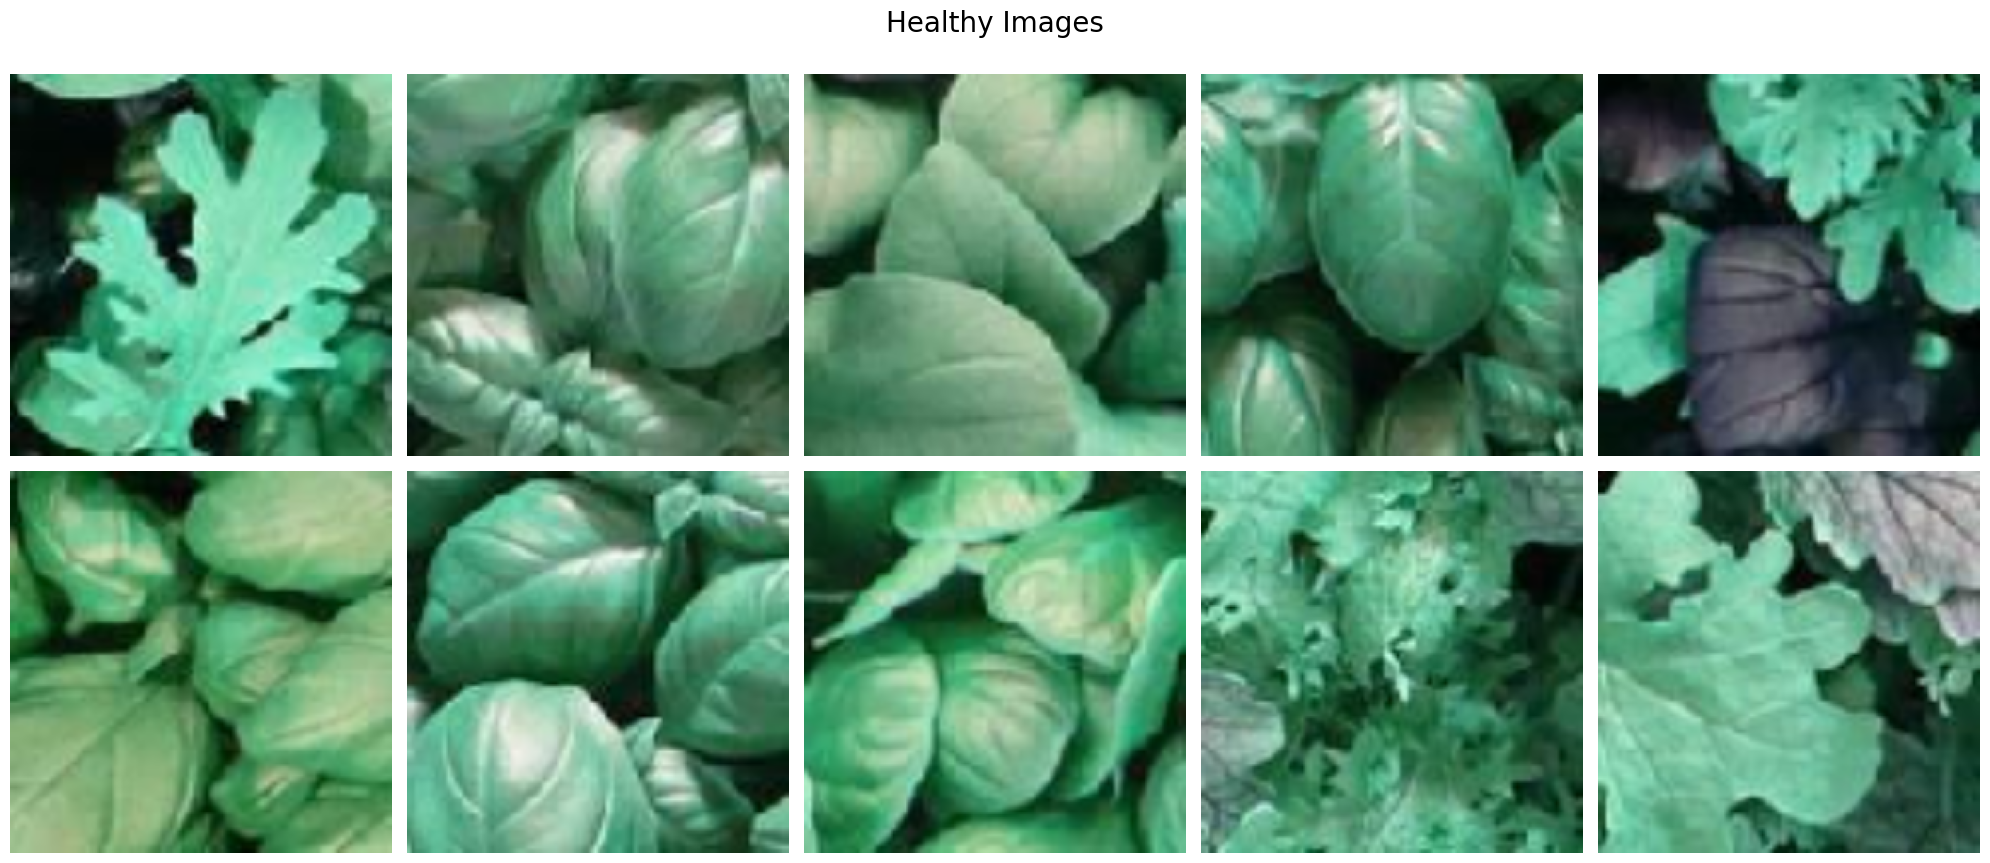

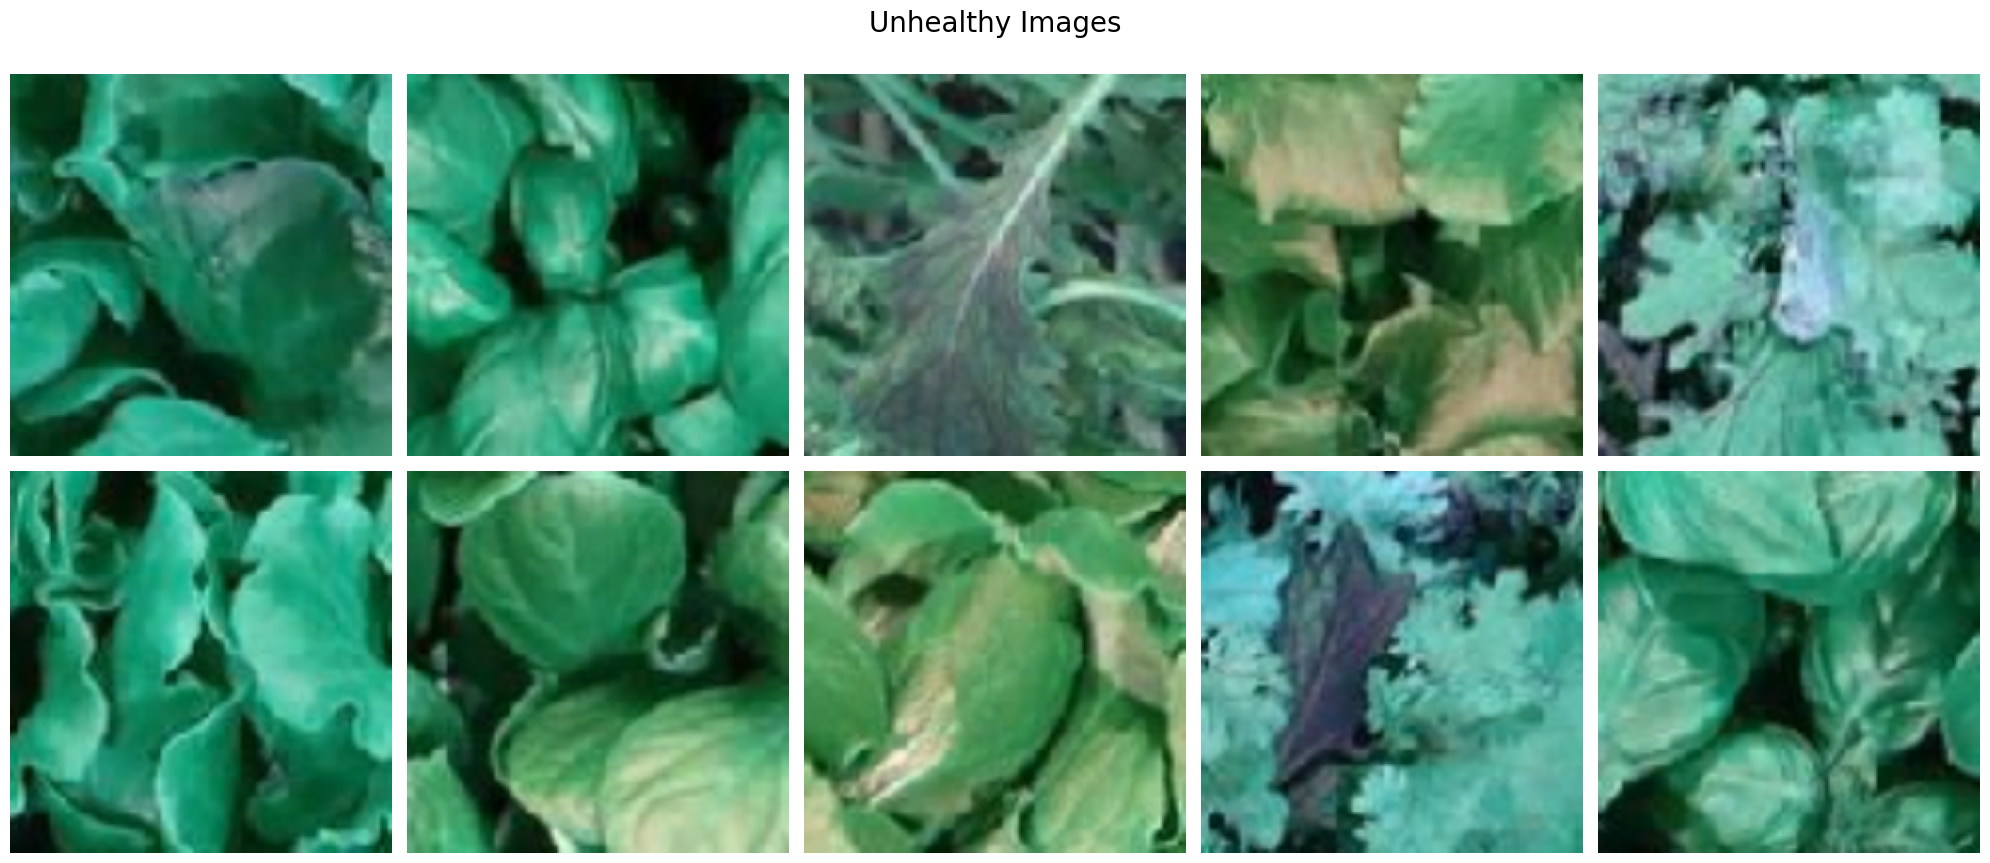

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying healthy images
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
fig.suptitle("Healthy Images", fontsize=20)
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(healthy_images[i], 0, 255))  # Display clipped healthy images
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create subplots for displaying unhealthy images
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
fig.suptitle("Unhealthy Images", fontsize=20)
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(unhealthy_images[i], 0, 255))  # Display clipped unhealthy images
    ax.axis('off')
plt.tight_layout()
plt.show()

## Prepare input for model

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)

# Create labels: 1 for 'healthy plants', 0 for 'unhealthy plants'
y = np.concatenate([np.ones(len(healthy_images)), np.zeros(len(unhealthy_images))], axis=0)
# Convert labels to one-hot encoding
y = tfk.utils.to_categorical(y,len(np.unique(y)))


In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.25, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (500, 224, 224, 3), y_train shape: (500, 2)
X_val shape: (250, 224, 224, 3), y_val shape: (250, 2)
X_test shape: (250, 224, 224, 3), y_test shape: (250, 2)


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (224, 224, 3), Output Shape: (2,), Batch Size: 32, Epochs: 1000


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='auto'),
]

### Train without augmentation

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 relu0 (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 mp0 (MaxPooling2D)          (None, 112, 112, 32)      0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 relu1 (ReLU)                (None, 112, 112, 64)      0         
                                                                 
 mp1 (MaxPooling2D)          (None, 56, 56, 64)        0       

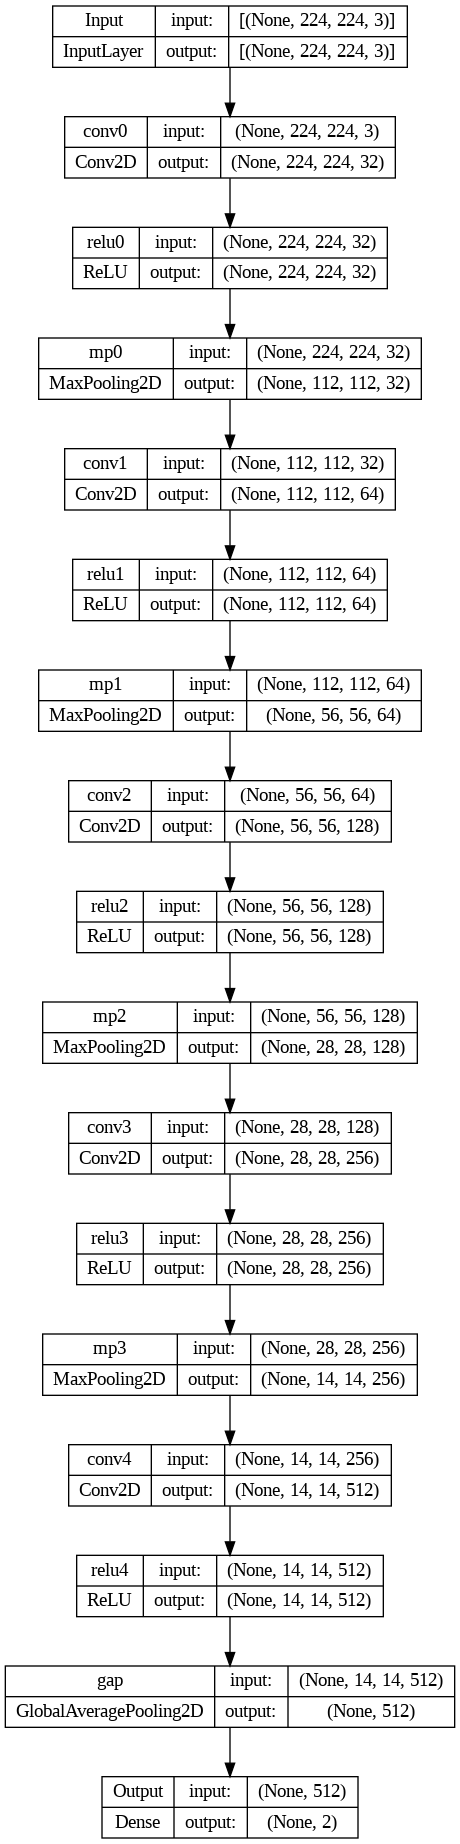

In [ ]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/1000
16/16 [==============================] - 16s 256ms/step - loss: 0.6960 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/1000
16/16 [==============================] - 1s 71ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.6847 - accuracy: 0.5140 - val_loss: 0.6895 - val_accuracy: 0.4720
Epoch 5/1000
16/16 [==============================] - 1s 79ms/step - loss: 0.6856 - accuracy: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/1000
16/16 [==============================] - 1s 71ms/step - loss: 0.6834 - accuracy: 0.5120 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/1000
16/16 [==============================] - 1s 86ms/step - loss: 0.6834 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.50

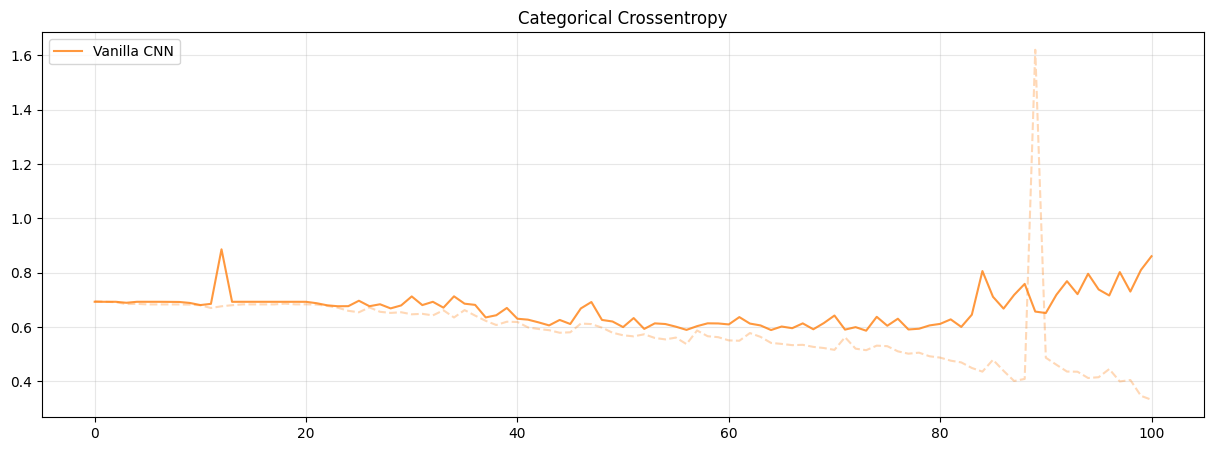

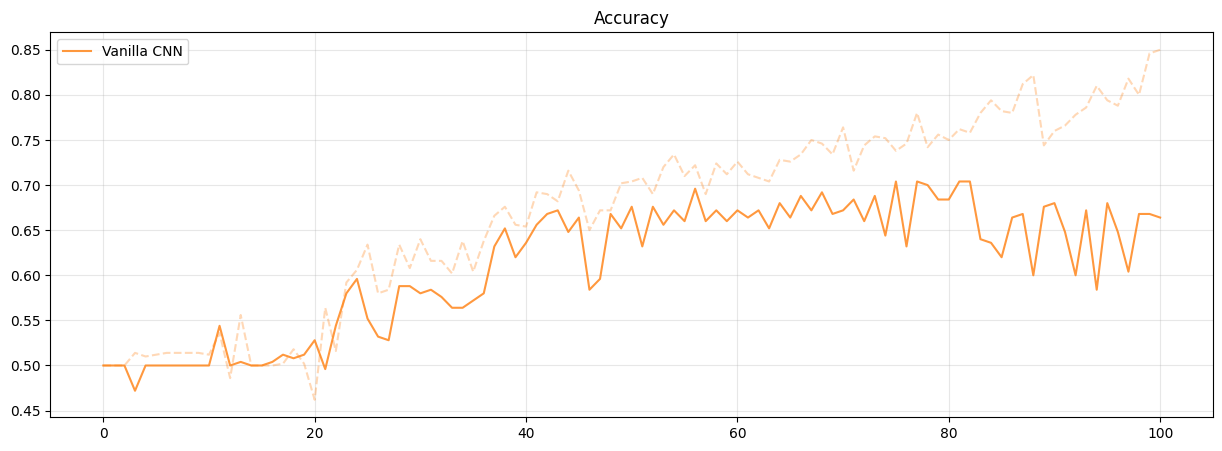

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

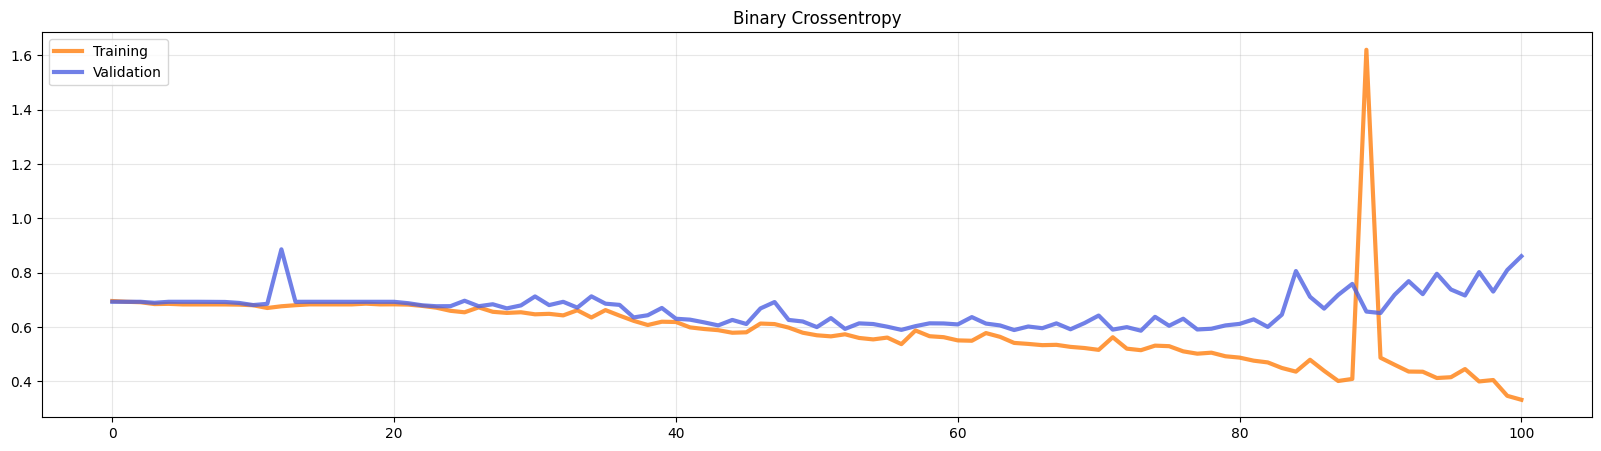

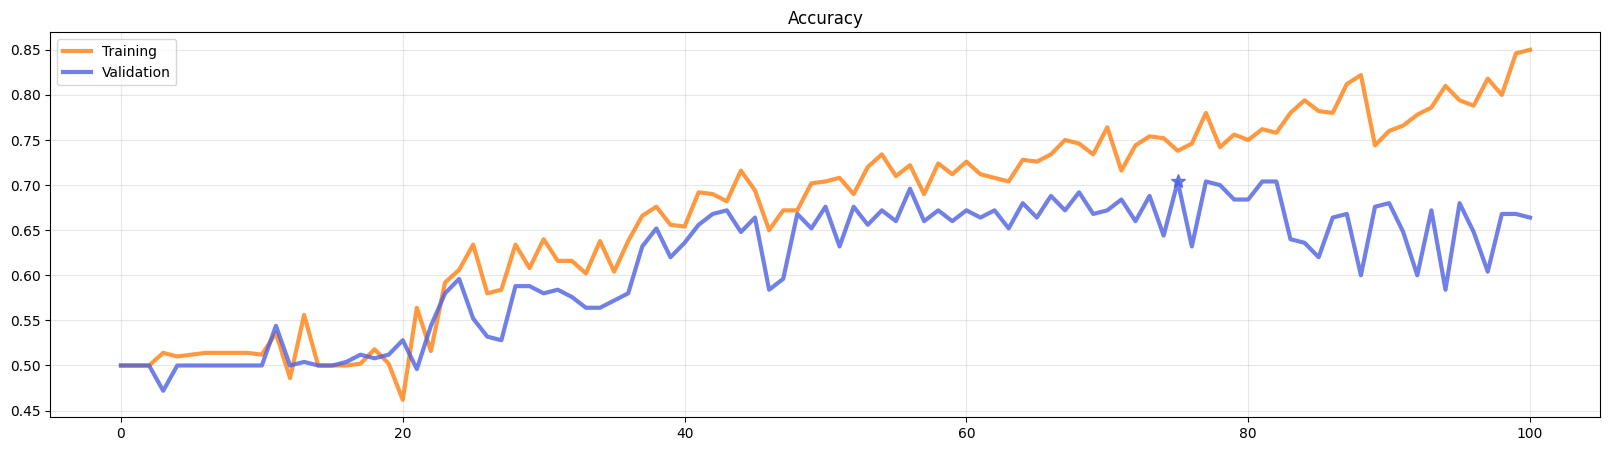

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (250, 2)


Accuracy: 0.752
Precision: 0.7876
Recall: 0.752
F1: 0.7441


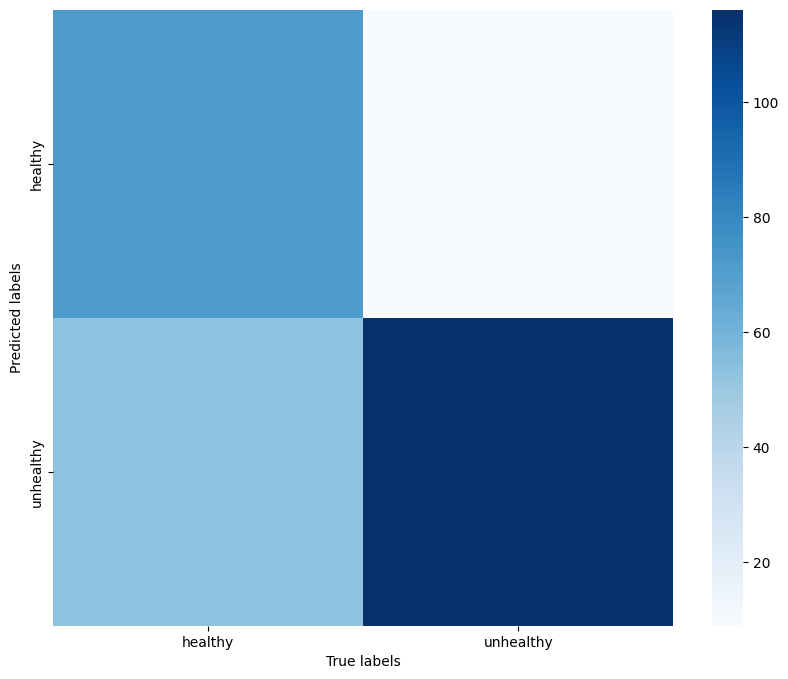

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()